## 数据集 https://www.kaggle.com/c/kobe-bryant-shot-selection
实战内容是用机器学习的方法来分析科比职业生涯数据的实例，利用随机森林算法训练处一个预测科比投篮模型。主要用了python的numpy，pandas，matplotlib和sklearn库。

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# import data
filename= "data.csv"
raw = pd.read_csv(filename)
print (raw.shape)
raw.head()

(30697, 25)


action_type combined_shot_type  game_event_id   game_id      lat  \
0          Jump Shot          Jump Shot             10  20000012  33.9723   
1          Jump Shot          Jump Shot             12  20000012  34.0443   
2          Jump Shot          Jump Shot             35  20000012  33.9093   
3          Jump Shot          Jump Shot             43  20000012  33.8693   
4  Driving Dunk Shot               Dunk            155  20000012  34.0443   

   loc_x  loc_y       lon  minutes_remaining  period   ...          shot_type  \
0    167     72 -118.1028                 10       1   ...     2PT Field Goal   
1   -157      0 -118.4268                 10       1   ...     2PT Field Goal   
2   -101    135 -118.3708                  7       1   ...     2PT Field Goal   
3    138    175 -118.1318                  6       1   ...     2PT Field Goal   
4      0      0 -118.2698                  6       2   ...     2PT Field Goal   

          shot_zone_area  shot_zone_basic  shot_zone_range     team_id  \
0          Right Side(R)        Mid-Range        16-24 ft.  1610612747   
1           Left Side(L)        Mid-Range         8-16 ft.  1610612747   
2   Left Side Center(LC)        Mid-Range        16-24 ft.  1610612747   
3  Right Side Center(RC)        Mid-Range        16-24 ft.  1610612747   
4              Center(C)  Restricted Area  Less Than 8 ft.  1610612747   

            team_name   game_date    matchup opponent  shot_id  
0  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        1  
1  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        2  
2  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        3  
3  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        4  
4  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        5  

[5 rows x 25 columns]

这个表格记录了科比30000多个镜头的详细数据，共有25个标签。

具体的设计思路是将这25个标签代表的数据进行分析，找出对科比投篮结果有影响的标签，利用机器学习中随机森林的算法训练出可以预测科比是否能够投篮命中的模型。

先来看看这25个标签具体代表什么(自己不是篮球的专业人士和爱好者，所以具体的内容可能有所出入，不过不会影响到分析结果)

* action_type（用什么方式投的篮）
* combined_shot_type（结合什么方式投篮）
* game_event_id（游戏事件ID）
* game_id（游戏ID）
* la（投篮的经度）
* loc_x （投篮的x坐标）
* loc_y（投篮的y坐标）
* lon（投篮的纬度）
* minutes_remaining（离比赛结束还有多少分钟）
* period（第几场）
* playoffs（是不是季后赛）
* season（赛季）
* seconds_remaining（离比赛结束还有多少秒）
* shot_distance（投篮离篮筐的的距离）
* shot_made_flag （是不是进球了(主要的标签)）
* shot_type（2分球还是3分球区域）
* shot_zone_area（投篮区域的表示方法一）
* shot_zone_basic（投篮区域的表示方法二）
* shot_zone_range（投篮区域的表示方法三）
* team_id（队伍ID）
* team_name（队伍名字）
* game_date（比赛时间）
* matchup（比赛双方队伍）
* opponent（自己所在队伍名字）
* shot_id（镜头ID）

可以看到，这25个标签中对于科比能否投篮命中有一些无关紧要的数据，比如team_id，因为这30000多份样本中全是在湖人队打的，shot_id，game_id等等这个数据也无关紧要

接下来我们再来分析这一份数据表，我们发现其中shot_made_flag这个标签竟然有缺失值，这个表示了科比是否进球了，作为最重要的数据，是不能随意进行填充的，我们必须删除掉这些样本进行下一步的工作，代码如下

![](https://tva1.sinaimg.cn/large/006y8mN6ly1g82idld7fjj308g0dymxm.jpg)

In [3]:
# 5000 for test
# 删除shot_made_flag为空的数据项，并且命名为kobe用作训练
kobe =  raw[pd.notnull(raw['shot_made_flag'])]
print (kobe.shape)

(25697, 25)


此时我们只有25697个数据进行训练了。

接着我们分析lat，loc_x，loc_y，lon这4个标签，这4个标签说明了科比投篮的位置，而具体指的是什么呢，有什么关系吗，我们画散点图来看一下。

编写代码如下

Text(0.5, 1.0, 'lat and lon')

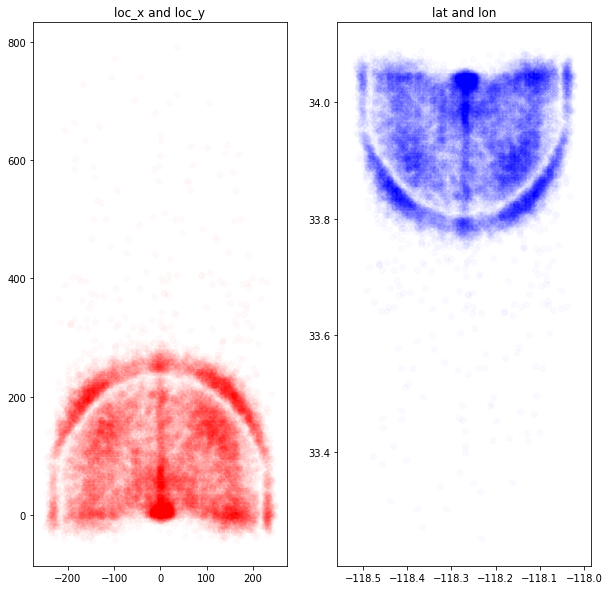

In [4]:
# plt.subplot(211) first is raw second Column
# 画散点图用来分析lat loc_x  loc_y lon这4个标签
alpha = 0.02 # 指定一个数字，用于后面的透明度
plt.figure(figsize=(10,10)) # 指定画图域

# loc_x and loc_y
plt.subplot(121) # 一行两列   第一个位置
plt.scatter(kobe.loc_x, kobe.loc_y, color='R', alpha=alpha) # 画散点图
plt.title('loc_x and loc_y')

# lat and lon
plt.subplot(122) # 一行两列   第二个位置
plt.scatter(kobe.lon, kobe.lat, color='B', alpha=alpha)
plt.title('lat and lon')

我们大致可以看出，这4个坐标大致表示了距离篮筐的距离，那样的话，我们接下来用于数据处理的时候选择其中的一组数据即可了。

shot_type，shot_zone_area，shot_zone_basic，shot_zone_range 这4个标签代表了投篮的区域，其实还是说明一件事，这里就不做赘述了，当然shot_zone_area，shot_zone_basic，shot_zone_range这3个标签将投篮区域相比于shot_type来说分的更细，直接删掉是不是会有问题，其实大可不必担心，因为，接下来我们将会用极坐标的形式表示科比的投篮位置，将更会细化科比的投篮区域。

/Users/lw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


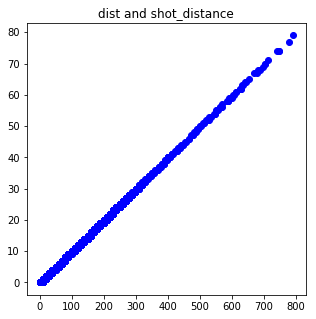

In [5]:
# 对于lat，loc_x，loc_y，lon这4个标签，我们取loc_x和loc_y这2个标签，并将其转化为极坐标的形式
# dist表示离篮筐的距离，angle表示投篮的角度，这样将会更好的科比投篮的反应结果
raw['dist'] = np.sqrt(raw['loc_x']**2 + raw['loc_y']**2)

loc_x_zero = raw['loc_x'] == 0
#print (loc_x_zero)
raw['angle'] = np.array([0]*len(raw))
raw['angle'][~loc_x_zero] = np.arctan(raw['loc_y'][~loc_x_zero] / raw['loc_x'][~loc_x_zero])
raw['angle'][loc_x_zero] = np.pi / 2 


#画图展示dist和shot_distance的正相关性
plt.figure(figsize=(5,5))
plt.scatter(raw.dist, raw.shot_distance, color='blue')
plt.title('dist and shot_distance')
plt.show()

这样我们可以保留其中的一个(这里我们保留了dist这个标签)，接着我们将minutes_remaining和seconds_remaining转化成一个标签remaining_time，然后删除不必要的列，非数值型的转换成onehot编码格式

具体编写代码如下，具体说明在代码注释中


In [ ]:
# 对于minutes_remaining：离比赛结束还有多少分钟；seconds_remaining：离比赛结束还有多少秒（0-60），这
# 2个属性我们合成距离比赛结束的时间
raw['remaining_time'] = raw['minutes_remaining'] * 60 + raw['seconds_remaining']

In [ ]:
print(kobe.action_type.unique())
print(kobe.combined_shot_type.unique())
print(kobe.shot_type.unique())
print(kobe.shot_type.value_counts())

In [7]:
kobe['season'].unique()

array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '1996-97', '1997-98',
       '1998-99', '1999-00'], dtype=object)

In [8]:
# 机器学习只能识别数值型的数据
# 将赛季中'Jan-00' 'Feb-01' 'Mar-02'  ···  '1998-99'转换成
# 0  1  2  ··· 99
kobe['season'] = kobe['season'].apply(lambda x: int(x.split('-')[1]) )
kobe['season'].unique()

/Users/lw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 97,
       98, 99,  0])

In [9]:
print(kobe['team_id'].unique())
print(kobe['team_name'].unique())

[1610612747]
['Los Angeles Lakers']


In [10]:
pd.DataFrame({'matchup':kobe.matchup, 'opponent':kobe.opponent})

matchup opponent
1        LAL @ POR      POR
2        LAL @ POR      POR
3        LAL @ POR      POR
4        LAL @ POR      POR
5        LAL @ POR      POR
6        LAL @ POR      POR
8        LAL @ POR      POR
9        LAL @ POR      POR
10       LAL @ POR      POR
11     LAL vs. UTA      UTA
12     LAL vs. UTA      UTA
13     LAL vs. UTA      UTA
14     LAL vs. UTA      UTA
15     LAL vs. UTA      UTA
17     LAL vs. UTA      UTA
18     LAL vs. UTA      UTA
20     LAL vs. UTA      UTA
21     LAL vs. UTA      UTA
22     LAL vs. UTA      UTA
23     LAL vs. UTA      UTA
24     LAL vs. UTA      UTA
25     LAL vs. UTA      UTA
26     LAL vs. UTA      UTA
27     LAL vs. UTA      UTA
28     LAL vs. UTA      UTA
29     LAL vs. UTA      UTA
30     LAL vs. UTA      UTA
31     LAL vs. UTA      UTA
38       LAL @ VAN      VAN
39       LAL @ VAN      VAN
...            ...      ...
30661    LAL @ IND      IND
30662    LAL @ IND      IND
30663    LAL @ IND      IND
30665    LAL @ IND      IND
30666    LAL @ IND      IND
30667    LAL @ IND      IND
30669    LAL @ IND      IND
30670  LAL vs. IND      IND
30671  LAL vs. IND      IND
30672  LAL vs. IND      IND
30673  LAL vs. IND      IND
30674  LAL vs. IND      IND
30675  LAL vs. IND      IND
30676  LAL vs. IND      IND
30677  LAL vs. IND      IND
30678  LAL vs. IND      IND
30679  LAL vs. IND      IND
30681  LAL vs. IND      IND
30683  LAL vs. IND      IND
30684  LAL vs. IND      IND
30685  LAL vs. IND      IND
30687  LAL vs. IND      IND
30688  LAL vs. IND      IND
30689  LAL vs. IND      IND
30690  LAL vs. IND      IND
30691  LAL vs. IND      IND
30692  LAL vs. IND      IND
30694  LAL vs. IND      IND
30695  LAL vs. IND      IND
30696  LAL vs. IND      IND

[25697 rows x 2 columns]

In [12]:
gs = kobe.groupby('shot_zone_area')
print (kobe['shot_zone_area'].value_counts())
print (len(gs))

Center(C)                11289
Right Side Center(RC)     3981
Right Side(R)             3859
Left Side Center(LC)      3364
Left Side(L)              3132
Back Court(BC)              72
Name: shot_zone_area, dtype: int64
6


Text(0.5, 1.0, 'shot_zone_range')

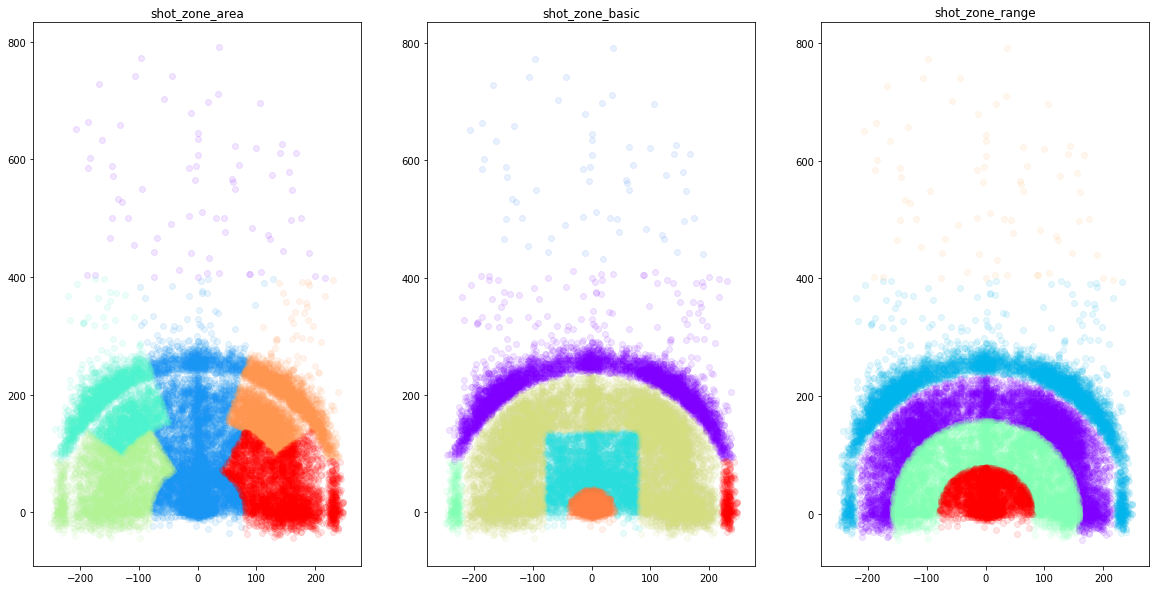

In [13]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = kobe.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')

In [14]:
# 删除对于比赛结果没有影响的数据
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', \
         'matchup', 'lon', 'lat', 'seconds_remaining', 'minutes_remaining', \
         'shot_distance', 'loc_x', 'loc_y', 'game_event_id', 'game_id', 'game_date']
for drop in drops:
    raw = raw.drop(drop, 1)

In [15]:
print (raw['combined_shot_type'].value_counts())
pd.get_dummies(raw['combined_shot_type'], prefix='combined_shot_type')[0:2]

Jump Shot    23485
Layup         5448
Dunk          1286
Tip Shot       184
Hook Shot      153
Bank Shot      141
Name: combined_shot_type, dtype: int64


combined_shot_type_Bank Shot  combined_shot_type_Dunk  \
0                             0                        0   
1                             0                        0   

   combined_shot_type_Hook Shot  combined_shot_type_Jump Shot  \
0                             0                             1   
1                             0                             1   

   combined_shot_type_Layup  combined_shot_type_Tip Shot  
0                         0                            0  
1                         0                            0

In [16]:
# 将非数值型的数据转换成为onehot编码的格式，加入到数据中并且将原来的数据删除
categorical_vars = ['action_type', 'combined_shot_type', 'shot_type', 'opponent', 'period', 'season']
for var in categorical_vars:
    raw = pd.concat([raw, pd.get_dummies(raw[var], prefix=var)], 1)
    raw = raw.drop(var, 1)
print(raw)

       playoffs  shot_made_flag        dist     angle  \
0             0             NaN  181.859836  0.407058   
1             0             0.0  157.000000 -0.000000   
2             0             1.0  168.600119 -0.928481   
3             0             0.0  222.865430  0.903063   
4             0             1.0    0.000000  1.570796   
5             0             0.0  145.416643  0.075717   
6             0             1.0    0.000000  1.570796   
7             0             NaN   28.017851  1.535097   
8             0             1.0  126.051577 -1.029016   
9             0             0.0  129.282636 -1.312685   
10            0             0.0  255.890602 -1.194644   
11            0             1.0  175.413796  0.809587   
12            0             1.0  128.798292 -1.023719   
13            0             0.0   94.085068 -0.042528   
14            0             0.0   52.325902 -1.115696   
15            0             0.0  201.762236  1.258450   
16            0             NaN

为什么会有129行之多，是因为我们用了onehot编码，具体什么是onehot编码这里就不做赘述了，感兴趣的可以谷歌或者百度一下。

最后我们总结一下，到底这25个标签还剩下什么，首先除去和比赛结果无关的标签，’shot_id’, ‘team_id’, ‘team_name’, ‘shot_zone_area’, ‘shot_zone_range’, ‘shot_zone_basic’,’matchup’, ‘lon’,   
‘lat’, ‘seconds_remaining’, ‘minutes_remaining’，’shot_distance’, , ‘game_event_id’, ‘game_id’,   
‘game_date’

然后’loc_x’, ‘loc_y’转换成了极坐标的形式，变成了’dist’,’angle’;’seconds_remaining’和’minutes_remaining’合并成了’remaining_time’。

最后将’action_type’, ‘combined_shot_type’, ‘shot_type’, ‘opponent’, ‘period’, ‘season’转换成onehot编码格式。

**至此我们的数据处理工作基本完成了。**

--

--

## 利用sklearn来进行数据的处理

具体的思路是利用随机森林分类器配合着交叉验证的方法进行数据的分析，先找到最佳的树的个数，和树的深度。

编写代码如下

In [31]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.
The scikit-learn version is 0.21.1.


For Sklearn 18 version import this:
"from sklearn.cross_validation import KFold"

For sklearn 20 import this:
"from sklearn.model_selection import KFold"

In [32]:
# 导入随机森林分类器
from sklearn.ensemble import RandomForestClassifier
# from sklearn.cross_validation import KFold
# https://stackoverflow.com/questions/30667525/importerror-no-module-named-sklearn-cross-validation
from sklearn.model_selection import KFold # 导入用于k折交叉验证的包

In [62]:

#将数据分为训练集和测试集

train_kobe = raw[pd.notnull(raw['shot_made_flag'])]

train_label = train_kobe['shot_made_flag']

train_kobe = train_kobe.drop('shot_made_flag', 1)

test_kobe = raw[pd.isnull(raw['shot_made_flag'])]
test_label = test_kobe['shot_made_flag']
test_kobe = test_kobe.drop('shot_made_flag', 1)

#print(train_kobe)
#print(train_label)
#print(test_kobe)


In [79]:
raw['shot_made_flag']

0        NaN
1        0.0
2        1.0
3        0.0
4        1.0
5        0.0
6        1.0
7        NaN
8        1.0
9        0.0
10       0.0
11       1.0
12       1.0
13       0.0
14       0.0
15       0.0
16       NaN
17       1.0
18       0.0
19       NaN
20       0.0
21       0.0
22       1.0
23       1.0
24       1.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
        ... 
30667    0.0
30668    NaN
30669    0.0
30670    0.0
30671    0.0
30672    1.0
30673    0.0
30674    1.0
30675    0.0
30676    1.0
30677    0.0
30678    0.0
30679    0.0
30680    NaN
30681    1.0
30682    NaN
30683    0.0
30684    0.0
30685    0.0
30686    NaN
30687    0.0
30688    1.0
30689    0.0
30690    0.0
30691    0.0
30692    0.0
30693    NaN
30694    1.0
30695    0.0
30696    0.0
Name: shot_made_flag, Length: 30697, dtype: float64

In [77]:
print(train_label)

1        0.0
2        1.0
3        0.0
4        1.0
5        0.0
6        1.0
8        1.0
9        0.0
10       0.0
11       1.0
12       1.0
13       0.0
14       0.0
15       0.0
17       1.0
18       0.0
20       0.0
21       0.0
22       1.0
23       1.0
24       1.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
30       1.0
31       0.0
38       1.0
39       1.0
        ... 
30661    1.0
30662    0.0
30663    0.0
30665    0.0
30666    0.0
30667    0.0
30669    0.0
30670    0.0
30671    0.0
30672    1.0
30673    0.0
30674    1.0
30675    0.0
30676    1.0
30677    0.0
30678    0.0
30679    0.0
30681    1.0
30683    0.0
30684    0.0
30685    0.0
30687    0.0
30688    1.0
30689    0.0
30690    0.0
30691    0.0
30692    0.0
30694    1.0
30695    0.0
30696    0.0
Name: shot_made_flag, Length: 25697, dtype: float64


In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix,log_loss
import time
from sklearn.preprocessing import OneHotEncoder

**损失函数分类：**

Zero-one Loss，Square Loss，Hinge Loss，Logistic Loss，Log Loss或Cross-entropy Loss，hamming_loss

分类器中常用的损失函数：

![](https://tva1.sinaimg.cn/large/006y8mN6ly1g82jx76zdjj30k2082q3s.jpg)

from sklearn.cross_validation import KFold自0.18版本弃用，在0.20中删除。改为使用：

sklearn.model_selection.KFold

参数：

n_splits：整数值，默认为3，最小为2

shuffle：True，每次抽样结果不同

               False，每次抽样结果相同

random_state：随机种子

In [37]:
import numpy as np
from sklearn.model_selection import KFold


X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])


kf = KFold(n_splits=2)
kf.get_n_splits(X)

print(kf)

KFold(n_splits=2, random_state=None, shuffle=False)

for train_index, test_index in kf.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

KFold(n_splits=2, random_state=None, shuffle=False)
TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]


[另一个简单的决策树版本的](https://segmentfault.com/a/1190000015321876)
[另一个特征提取的版本](https://cupdish.com/2016/06/15/kobe/#%E9%A2%98%E7%9B%AE%E6%95%B0%E6%8D%AE%E5%88%86%E6%9E%90)

![](https://tva1.sinaimg.cn/large/006y8mN6ly1g82jo03o50j30df0aeq4d.jpg)

## 随机森林（Random Forests）

随机森林是一种重要的基于Bagging的集成学习方法，可以用来做分类、回归等问题。

随机森林有许多优点：

* 具有极高的准确率
* 随机性的引入，使得随机森林不容易过拟合
* 随机性的引入，使得随机森林有很好的抗噪声能力
* 能处理很高维度的数据，并且不用做特征选择
* 既能处理离散型数据，也能处理连续型数据，数据集无需规范化
* 训练速度快，可以得到变量重要性排序
* 容易实现并行化

随机森林的缺点：

* 当随机森林中的决策树个数很多时，训练时需要的空间和时间会较大
* 随机森林模型还有许多不好解释的地方，有点算个黑盒模型

https://blog.csdn.net/qq547276542/article/details/78304454

![](https://tva1.sinaimg.cn/large/006y8mN6ly1g82jsl7w92j30qv0lxgoo.jpg)

In [80]:
from pprint import pprint
import scipy as sp
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

In [82]:
# find the best n_estimators for RandomForestClassifier
# 寻找随机森林分类器的的最佳树的数量...
print('Finding best n_estimators for RandomForestClassifier...')
min_score = 100000
best_n = 0
scores_n = []
# logspac用于创建等比数列
range_n = np.logspace(0,2,num=3).astype(int)
print(range_n)
counter = 0

for n in range_n:
    print("the number of trees : {0}".format(n))
    t1 = time.time()
    
    rfc_score = 0.
    
    ## 随机森林分类器
    rfc = RandomForestClassifier(n_estimators=n)
    # for train_k, test_k in KFold(len(train_kobe), n_folds=10, shuffle=True): # 旧代码
    
    # kf = KFold(len(train_kobe),  shuffle=True)
    kf = KFold(500,  shuffle=True)
    
    for train_k, test_k in kf.split(train_kobe):
        counter +=1
        ## Build a forest of trees from the training set (X, y).
        ## 为测试集构建一个包含树的森林
        rfc.fit(train_kobe.iloc[train_k], train_label.iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        # Predict class for X. 预测
        pred = rfc.predict(train_kobe.iloc[test_k])
        # print("Current Testing",test_k)
        testLable = train_label.iloc[test_k]
        # print("TestLable",testLable)
        #print(testLable)
        #pprint(vars(testLable))
        # print(train_kobe.iloc[test_k])
        # print("Predict",pred)
        rfc_score += log_loss(testLable,pred) / 10
        
        print("N",n,"TRAIN:",train_k, "TEST:",test_k,"Counter",counter,'rfc_score',rfc_score)
    scores_n.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_n = n
        
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(n, t2-t1))
print(best_n, min_score)

Finding best n_estimators for RandomForestClassifier...
[  1  10 100]
the number of trees : 1
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  148   305   506   938   997  1508  1952  2168  2224  2363  2567  5136
  5954  6012  6340  7308  7400  7585  8427  9251  9489 12013 12469 12502
 13110 13265 13511 13572 14213 14256 14762 14790 16146 16501 18220 18236
 19984 20062 20115 20780 21171 21290 21641 21780 21781 23751 23925 24133
 24157 24341 24349 24690] Counter 1 rfc_score 1.6605380858449224
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  846  1138  2512  3009  3615  3771  4073  4122  4282  4440  4492  4658
  5663  5834  6689  7049  7273  7709  7880  8524  9018  9332 10131 10939
 11446 11928 12035 13010 13736 14112 15056 15648 15745 15945 17334 17429
 17496 18230 18426 19337 19921 20099 20528 20958 21086 21235 21714 22136
 22434 23685 24726 25060] Counter 2 rfc_score 3.1882347240171116
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  520   744   

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  156  1075  1800  3487  5066  5664  6220  6945  8459  9499 11904 12137
 12553 14489 14702 15364 15486 15491 15639 15694 15964 16448 16640 16726
 17391 17588 18549 18651 18670 18981 18984 19902 20245 20361 20554 21373
 21694 22204 22791 22930 23201 23527 23555 23694 24004 24442 24492 24608
 24678 24841 25118 25382] Counter 22 rfc_score 31.15165777047645
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  312   449  1734  2064  3917  4008  4770  5301  5708  5996  6126  6195
  6548  6664  6913  7464  8120  8832  8936  9992 10296 10483 10622 11350
 11456 11968 12240 12747 12770 13788 14087 14212 15180 15555 15756 15939
 16329 16630 17629 20076 20125 20203 20464 20722 21175 21207 23622 24509
 24628 24859 25084 25676] Counter 23 rfc_score 32.41366382486635
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 2517  2574  2932  3724  4319  4855  4929  5370  5929  6445  6671  6679
  7243  7298  7603  8128  8254  8587

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  146   665   877  1097  1558  2201  2801  4889  5138  8144  8188  8546
  8863  9301  9384  9414  9675  9904 11314 11516 12165 12518 13087 14066
 14721 15622 15962 16078 16437 17256 17545 18569 18674 19241 19724 19817
 19833 19949 20293 20467 21916 22269 22405 22423 22480 22893 23584 24208
 24950 24985 25385 25678] Counter 42 rfc_score 60.11141166441704
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   17    40   243  1234  1500  2518  3014  3972  4240  4851  4854  5341
  5687  6511  6625  6669  6783  7641  9379 10148 10188 10469 10589 10813
 10862 12153 12356 13182 13628 13952 14460 14540 14555 14677 16652 16902
 16904 17763 18005 18052 19229 20894 20971 21244 21435 22082 23551 23657
 23921 24986 25090 25550] Counter 43 rfc_score 61.50626531722913
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  594  1066  1490  1659  1753  3498  3647  3840  4619  4677  5039  5627
  6193  8200  9111  9365  9370  9394

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  850  1988  3418  3434  4213  4218  4395  4625  4844  5287  5411  6263
  6379  6586  6685  7698  7887  8116 10354 10365 10406 10797 11355 11428
 12479 12519 12745 13673 13725 14245 14384 15435 15497 16135 16452 16903
 16937 18408 19764 21089 21203 21457 21527 22729 22761 23015 23097 23505
 24180 24202 24422 25585] Counter 64 rfc_score 91.46235159633831
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  110   211   462   487   973  1057  1761  2153  2741  2842  5108  5602
  5958  5994  6046  6503  6958  8465  8696  8822  8889  9897 10548 11187
 12241 13295 13462 13529 13643 13763 14621 15218 15501 16548 16698 16860
 17146 17277 17647 17700 17900 17943 18468 18638 19301 21276 22910 23037
 24141 25115 25119 25341] Counter 65 rfc_score 92.8572052491504
N 1 TRAIN: [    1     2     3 ... 25694 25695 25696] TEST: [    0   119   966  1399  2459  2898  2930  3164  3367  4459  4775  5012
  5402  5744  6672  7253  8646  9485 

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  624   875   946  1124  1535  2480  2861  2867  4592  5902  6535  8675
  9524  9584  9989 10279 11128 11677 12430 12784 12814 13151 13296 13570
 14296 14475 15144 15426 15635 16087 16112 16238 16309 17020 17243 17436
 17655 17732 17829 18090 19679 20871 20962 22244 22884 23625 23659 24142
 24401 25031 25166 25639] Counter 86 rfc_score 124.07529912033688
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   78  1682  1840  1878  3551  3587  3834  3855  3886  5215  6029  7699
  7981  9242  9490  9583 10064 10875 12660 12661 13072 13924 14006 14361
 15120 16018 16230 17022 17268 17343 17531 17945 18017 18478 18941 19154
 20014 20490 20550 20582 20765 20974 20995 21049 21314 22762 22908 22939
 23725 23765 24955 25551] Counter 87 rfc_score 125.66941186928334
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  120   465  1266  2374  2998  3173  3497  3753  4701  4734  5376  6106
  6508  7413  7810  8262  8657  89

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  332   860  1199  1265  2546  2970  3186  3208  4242  5343  5442  6466
  6870  7344  8770  8965  9417 10293 10521 10559 10591 11196 11822 12896
 13472 13544 13879 14072 14911 15789 15997 16005 17362 17809 18138 18676
 19297 19298 19376 19389 19711 19854 20900 21187 21259 22070 22858 22887
 23384 23522 23645 24796] Counter 107 rfc_score 154.0978291885929
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   37   928  1048  1205  1236  1503  1666  2044  2088  2554  3423  3599
  4060  4424  4600  5169  5869  6510  6761  7032  9128  9815  9921 10103
 10340 10597 11301 12444 12632 12699 12877 12963 13500 15490 15612 16780
 17067 17199 18541 18686 18783 19233 20128 20819 21414 22031 22036 22340
 23676 23914 25394 25542] Counter 108 rfc_score 155.5591004898666
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   28  2322  2582  2644  4111  5279  5391  5513  6476  6729  6933  6959
  7538  8634  8867  8929  9610 100

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  347   653   656   862  1698  1829  2769  3964  4028  4816  5220  5259
  5827  6304  6492  6701  6825  6872  7150  7852  7923  8698  9807  9994
 11999 12170 13126 14530 14805 15007 15358 15742 16260 16500 17158 17289
 17550 17690 18044 18369 18732 19088 19471 19908 20874 21252 22081 23028
 23978 24104 24515 24930] Counter 128 rfc_score 185.05021709912344
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   54   517   554  1614  1726  2396  2432  2520  3594  4108  4563  4839
  4947  5956  7306  8323  8613  9253  9254  9470 10288 10975 11063 11308
 12027 12920 14089 14880 14899 15118 15261 15754 15835 17338 17636 18398
 18487 18698 19482 19873 20469 20847 20850 21045 21296 22369 22449 22891
 23288 23542 25105 25136] Counter 129 rfc_score 186.24580704273907
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  580   950  1844  2261  2462  2548  2876  3484  3523  3783  4206  5004
  5245  6441  6817  7427  7771  

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  611   784   865  1634  2232  2239  2831  2917  3003  3127  3245  3390
  3539  4149  4749  5424  5826  5852  6562  6598  6677  7417  7732  8112
  8409  8512  9143  9359  9835 10409 11464 11705 12208 12935 13121 16537
 16867 17628 17689 18367 19027 19196 19809 19831 21268 21946 22779 23087
 23169 23990 24724 25366] Counter 148 rfc_score 212.68159495852083
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  171   344   896  1324  1329  1850  2319  2321  3609  3740  4716  5601
  5608  5807  6035  6115  6117  6347  7318  7512  7728  8058  8314  8743
  8877  8957  9978 10471 10510 11601 12679 12722 13549 13970 15057 15157
 15276 16450 17926 18428 18472 18669 19221 21243 21897 22697 22961 23067
 23096 23135 23803 24235] Counter 149 rfc_score 213.54507513220517
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [    7   510   890  1206  2008  2021  4115  4356  5081  5577  5736  6393
  6431  7442  7465  7573  8747  

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  525   752  1931  2786  3134  3141  3335  4341  4368  4786  4946  5388
  5796  7616  7723  7794  8935  9088  9556 10036 10112 10334 10534 11380
 11506 12510 12686 13245 13425 13636 13990 13993 14409 14604 15640 16240
 17476 18979 19200 20390 20594 20743 21115 21622 22343 22506 23309 23804
 24255 24460 24634 25339] Counter 169 rfc_score 243.43474683822743
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  176   975  2688  3178  3920  3941  4158  5030  5326  5486  5747  7143
  7508  8094  9323 10574 10767 11155 11248 11592 12105 12673 12831 13433
 13891 14543 14923 15937 16901 17432 17641 17814 17954 19042 19257 19432
 19553 19927 20096 20153 20363 20777 21196 21338 22129 22584 22609 22703
 23013 24411 24973 25155] Counter 170 rfc_score 244.56390836956984
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  153   995  1070  1352  1618  2272  2618  2816  3482  3751  4328  4490
  5422  6072  7437  7467  7697  

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  273  1655  1813  2062  3199  3404  3704  5209  5233  6001  6546  7704
  7941  8008  8298  8612  9537  9863  9960 10229 11142 11300 12047 12163
 12473 12717 13767 13908 14596 14707 14837 14879 15282 15858 16673 17087
 17352 17957 19262 19519 19594 19977 20195 20712 21487 21972 22030 22144
 22432 23157 23198 24977] Counter 189 rfc_score 270.3354367656176
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  215   745  1284  1368  1378  1437  1681  2382  3271  3590  3868  4000
  4002  4275  5599  5905  6519  8326  8560  8789 10741 10892 11614 11835
 13026 14269 14465 14606 14985 15044 15646 16201 16523 16597 16733 16980
 17445 17495 18527 18836 19259 19335 19880 20055 20929 21199 21366 22192
 22286 23098 24954 25481] Counter 190 rfc_score 271.9295433638146
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  186   654   899  1288  1293  1392  2236  2237  2556  2854  4265  4321
  5010  6203  6260  7668  8684  88

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  401   639  1297  1330  2358  2920  3435  3739  4883  5730  6344  6581
  7134  7210  8114  9035  9235  9442  9469  9557 10113 10696 10764 10810
 10849 10982 12449 12958 13263 13873 14355 16061 16386 17882 18012 18164
 18235 18379 18555 19410 20117 20389 21485 21712 22017 24064 24882 25203
 25212 25364 25565] Counter 209 rfc_score 301.10551130751963
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  771   894  1811  2883  3072  3092  4258  4652  4664  4750  5062  5652
  5686  6079  6390  6985  7025  7431  7561  8741  9674 11404 12889 13228
 13514 14189 14204 14861 14915 15103 16390 17555 18015 18603 19072 20060
 20909 21040 21127 21311 21579 21705 21909 22944 23258 23602 24315 24353
 24536 24589 24743] Counter 210 rfc_score 302.86633362248375
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  257  1361  1402  1455  2198  2245  2416  2601  4246  4472  5952  6565
  6568  8265  8478  8536  8699  9476  9571  

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   58   790  2033  2424  2931  3097  3449  3663  4004  4184  4201  4498
  4674  4973  6091  6180  6642  7195  7870  8927 10816 11164 11402 11837
 12233 12873 13515 15174 15650 16081 16167 16244 16711 17214 17645 18088
 18223 18340 18885 19548 20012 20498 20508 20537 20999 21195 21578 21819
 23531 23844 24022] Counter 229 rfc_score 329.68493320437733
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  178   898  1179  1278  2120  2638  2760  3116  3242  3555  4615  4817
  5292  5559  5655  6275  7141  7347  7575  8855 10927 11016 11185 11551
 11912 12049 12054 12081 12370 12464 12489 12724 12740 12909 14228 14275
 14401 14487 14547 14576 14789 14984 16527 17007 17288 17836 18362 19343
 21258 21517 22225] Counter 230 rfc_score 331.44575865501764
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  325   566   833  1364  1475  1947  2650  3980  4660  5294  5724  6044
  6139  6222  6760  6775  7850  8085  8598  

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  259   358   551  1648  1930  2446  2805  3037  3094  3558  3616  3889
  5197  5252  5558  6016  6367  7321  8260  9290  9303  9454 10558 10911
 10916 12235 12429 12739 13073 13106 13743 13875 14347 14417 14922 16266
 16515 17604 19803 19999 20084 21027 21484 21616 21762 21794 21833 21991
 22959 23010 23026] Counter 249 rfc_score 361.0410880621175
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  820   821  2315  2511  3683  3733  3899  4746  4882  5085  5692  5979
  6932  8347  8352  8650  9201 10639 11631 12120 12152 12574 12708 13173
 13222 13687 13927 14508 15918 17216 17426 17566 17672 17798 18134 18987
 19036 19316 19767 19891 20111 20143 21438 21656 22536 22919 23550 23977
 24321 24552 25590] Counter 250 rfc_score 362.7341857182731
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  886  1445  2032  2126  2882  3574  3700  4487  4496  4661  5509  6290
  6364  6395  6735  7354  8440  8473  8885  93

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  427   513   539  1245  2308  2482  3652  4429  4519  5390  5894  6033
  7211  7425  7454  7932  8354  9120 10166 10392 10549 10857 11948 12112
 12790 12893 13006 15082 15094 15106 16429 17073 17298 17526 18063 18226
 18714 19326 19369 19950 20949 20987 21381 21663 22016 22912 23021 23975
 24113 25144 25370] Counter 271 rfc_score 394.0226315955856
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  599   895  1294  1687  1739  2837  3075  3667  3858  4071  4907  5546
  5743  5949  6252  6470  7104  7682  7690  7958  9239  9645  9810 10394
 10858 11111 12674 13133 13989 15602 15817 16676 17076 17368 18351 18440
 18871 18973 19310 19449 19647 21087 21401 21855 22380 22950 23877 24776
 25395 25492 25675] Counter 272 rfc_score 395.5802815019623
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   36   317   701  1492  2256  2296  2764  2862  2890  3654  3901  4026
  4084  4806  5468  5478  5618  6114  7061  70

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  282  1150  1249  1750  3096  3143  3326  3930  4030  4293  4378  5133
  5497  6181  6401  8022  8269  9044  9605 10147 10830 11807 12426 14100
 14102 14319 14344 15325 16277 16278 16862 17131 17442 17554 18309 18457
 18718 18757 19388 19686 19791 20097 20778 21684 21805 22211 22494 24311
 25088 25225 25425] Counter 293 rfc_score 424.1597222128772
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  335   900  1526  2018  2284  2312  2325  4112  4634  5907  6271  6610
  6674  7486  7896  8550  8881  9269  9355 11327 11353 12585 12593 13381
 13609 13779 15067 16805 17200 18144 18266 19459 19596 20030 20436 20942
 20966 21117 21257 21291 21620 21674 22177 22446 22730 23703 23755 24354
 24650 24799 25683] Counter 294 rfc_score 425.98826605097366
N 1 TRAIN: [    0     1     2 ... 25693 25694 25695] TEST: [  301   897  3811  3839  3873  4037  4344  4413  4668  5218  6402  6921
  7345  7749  8115  8452  8922  9668  9773  9

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  410   629  1517  2389  2445  3234  5035  5609  5844  6145  6319  9001
  9933 10231 10289 11167 11688 11790 12131 12293 12592 12753 12835 13742
 14258 14323 14341 14719 15480 16024 16383 16463 17039 17174 17459 18668
 18679 19536 20028 20388 20477 21773 22532 22770 23113 24246 24260 24319
 24817 25027 25331] Counter 313 rfc_score 456.1254021355702
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   59    64  1789  1857  2807  2879  3319  4189  4886  4985  5312  5666
  6341  6490  6498  6545  7075  7790  8229  8507  8638  9407  9436  9455
  9533 10236 10647 11560 11716 11803 13707 14704 14931 14950 15465 17529
 17741 18951 19397 21009 21598 22071 22430 22685 22688 23508 24084 24413
 24533 25095 25517] Counter 314 rfc_score 457.41215340671283
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  456   526   550   628   666  1619  2067  2217  3331  4411  4940  5211
  5583  5804  6173  7365  7570  8168  8488  8

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  183  1546  1894  2037  2051  2306  2375  2423  2474  2537  2624  2715
  2916  3657  3662  4462  4863  5008  5091  5439  5919  6170  6811  6829
  7005  8307  8963  9125 10705 11381 11469 11538 11800 12876 13180 16389
 17162 18315 18978 19239 20970 21428 21657 22659 23470 24015 24065 24394
 24789 24942 25101] Counter 334 rfc_score 484.8403000032925
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  135   721   871  1246  1895  2028  2727  3303  3356  4423  4491  5449
  5635  6534  8090  8516  9441  9906 10015 10017 10723 10853 11642 12020
 12383 13508 14477 14520 14855 14868 15280 15924 16189 16341 16373 16459
 16883 17177 18099 18727 19558 19997 20386 20602 21052 21838 21859 21902
 24445 24752 25192] Counter 335 rfc_score 485.9916129316848
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1418  1497  1825  2139  2152  2836  3606  5061  5129  5548  6111  6162
  6897  7945  8108  8344 10613 10728 11500 120

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  131   762  2726  3062  3262  4468  5640  6529  6704  6807  7530  8142
  8170  8313  8327  8549  8610  8680  8951  8978  9341  9673 10412 10749
 11564 11641 11731 11774 13449 14364 15594 15803 16273 16651 16799 16866
 16949 16993 17336 18893 19336 19486 19816 20140 20785 21342 21920 22976
 23192 23357 25152] Counter 355 rfc_score 514.4356262747161
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  208   683   757   813  1279  1939  1999  2066  2307  2402  2856  3785
  4152  4375  5217  5760  5776  6030  7283  7359  9925 10003 10210 11040
 12928 14607 14717 14995 15770 15947 16143 16419 17179 17248 17258 17770
 17911 18859 18921 19220 19223 19315 21931 22946 23451 24054 24210 24461
 24660 24705 25474] Counter 356 rfc_score 516.0609961363871
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  145   363   646   759  1799  2049  3395  3602  4264  4325  4941  6638
  7007  7185  7186  8198  8369  8611  8900  94

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1963  2144  2419  2621  2658  3568  3743  3860  4186  4224  4584  5068
  5399  5435  5923  6297  6660  9133  9802 11083 11452 11581 12466 13070
 14095 14396 14902 16362 16675 16701 17281 18006 18413 19270 19295 19349
 19530 19633 19805 19964 20196 20246 21421 21844 21921 22352 22757 23085
 24502 25221 25545] Counter 376 rfc_score 547.4171431549369
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1954  3798  3856  6097  6694  6780  6956  7288  7418  7422  7808  8402
  8756  9894 10732 10977 11029 12194 12413 12681 13419 13441 13652 13810
 13951 14113 14143 14893 15015 15034 15464 16350 16900 17705 17791 18049
 19427 19589 21396 21835 22574 22799 23044 24034 24052 24564 24906 24920
 25098 25447 25564] Counter 377 rfc_score 548.771619084888
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  187  1086  2059  2305  3060  3372  3437  4684  5051  5498  6801  6809
  6865  8356  8558  8976  9165  9514  9959 1024

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  296  2093  2486  3747  4611  4728  4733  4847  4980  5413  6421  7864
  7974  8471  8777  8862  9236  9561  9617 10008 10142 10684 10766 12012
 12070 13645 13731 14302 14529 14556 15399 15892 16690 18465 18813 19005
 19157 19920 20224 20311 20631 20744 21241 22213 22825 23889 24294 24356
 25262 25552 25658] Counter 397 rfc_score 577.4188361932686
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  111   234  1069  1360  1423  2103  3478  3711  4185  4381  4534  4570
  4977  5190  5634  5646  6041  6100  6204  6606  6656  7915  8429  8632
  8987  9589  9912 10692 10848 11163 12155 12435 12552 12694 13201 13676
 14111 14446 15810 17038 18316 18738 19187 19704 22376 23106 23134 23392
 23578 24033 24655] Counter 398 rfc_score 578.773316826734
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1046  2671  3172  4827  5587  6052  6243  8178  8505  9814  9972 10584
 10754 10883 10921 11026 11611 11630 12026 1287

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  132   173  1453  3144  3685  4605  5167  5511  6472  6706  6882  7260
  7468  7589  7922  8338  8930  9451  9795  9857  9918 10170 10273 10784
 11056 11067 11858 12425 13209 13231 13404 15820 16802 17965 18091 19363
 19384 20296 21232 22360 22463 22879 23277 23362 23400 23564 23583 23674
 24691 25102 25495] Counter 417 rfc_score 607.5559675743507
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  182   416   532  1415  1440  1818  2472  2911  3028  3159  3229  3686
  3784  3962  4942  5508  6541  6800  7028  7156  7220  7684  9766 10245
 10339 11095 12830 13776 14199 14422 14424 17045 17160 17610 18150 18321
 18521 19047 19588 19782 20357 20450 21267 21602 23266 23639 24041 24207
 24382 25219 25513] Counter 418 rfc_score 609.0458912540807
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  238   367   499   537   735   905   974  1837  1914  2613  5309  5358
  6014  6300  6972  6990  8393  8913  8985  96

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  180   371   516  1547  1733  1760  1778  2732  3200  4386  4700  5516
  5891  6306  6815  8441  8509  9161 10338 10519 10793 11362 11809 12278
 12644 12792 13281 13477 13658 13808 13901 14383 14655 14944 15755 16073
 16262 17083 17457 17613 17893 17970 18994 19772 20410 20849 21110 22565
 23770 24499 24598] Counter 437 rfc_score 634.9164334115889
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  134   507  1883  2656  3093  3531  3668  3703  4126  4310  4401  5059
  5492  5506  5696  6076  6446  6749  7666  7895  8002  8331 11000 11357
 12507 12625 13018 13649 14218 14366 14427 14832 16634 16719 16874 17139
 18254 18621 19399 20470 21659 22042 22454 22511 23136 24231 24493 25232
 25358 25484 25657] Counter 438 rfc_score 636.5417954340693
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  842  1560  1672  2674  2906  3877  3888  4228  4348  4516  4877  5397
  5715  6207  6209  7023  8009  8230  8407  89

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  147   402  1280  1824  1901  1995  3021  3065  3260  3265  4335  4365
  4841  5086  5092  5704  6784  7184  7228  7322  8063  8417  8919 11177
 11930 12090 14117 15402 15802 15855 16410 16554 16843 16972 17330 17580
 17682 18265 18695 19895 20107 20139 20865 21248 21520 21998 23052 23638
 24331 24784 25013] Counter 457 rfc_score 665.4598751174078
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  565   595   695  1417  2433  2491  2693  3363  3631  4196  4511  4771
  5145  6166  7170  7398  7975  8379  8547  8677 10123 10156 10960 11209
 11366 11536 12501 14175 14179 14515 14563 14740 15277 15846 16190 19485
 20733 21098 21375 21928 22349 22889 23720 23949 24063 24704 24951 25210
 25383 25390 25535] Counter 458 rfc_score 666.8143541830352
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1022  1366  1436  1481  1637  1770  1860  2444  2877  3104  3316  3421
  3442  3617  3793  4029  5226  5741  5813  62

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  529  1272  1627  1817  1949  3263  3485  3682  4039  4148  4525  5879
  7076  7206  7578  7679  8087  9646  9903  9938 10111 10890 11527 13159
 13842 14320 14956 15584 16477 16643 16746 17182 17527 17620 17964 17973
 18195 18248 18310 18913 19108 20082 20815 22084 22521 23116 23650 23872
 23875 23899 24718] Counter 477 rfc_score 692.3462761821769
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  671   723  1035  1259  1451  1700  2207  3659  4100  4447  4955  5527
  5604  5962  6192  7924  8180  8411  8525  8585  8907  9973  9974 10027
 10280 10316 11386 11721 12164 12222 12639 13267 14494 14511 14792 15741
 16154 17558 17711 18062 18711 18802 19106 20877 22050 23690 23701 24191
 24347 24975 25248] Counter 478 rfc_score 694.2425399755675
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  190   276   615  1584  1713  1955  3806  3852  4130  4303  4790  6439
  6986  7164  7285  7342  7722  7857  8776  98

N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  498   841  1237  1446  2347  2789  3695  3755  4237  4239  4458  5173
  5185  5393  5822  5880  7663  7712  8047  8264  8462  8795  9383  9900
 10232 10312 10421 10675 11479 11908 11914 12121 13576 13932 14277 15189
 15562 15882 16959 17848 18169 20323 20404 20580 21048 22287 22399 22621
 22848 24890 25113] Counter 498 rfc_score 724.1765114907668
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  621   764  2031  2159  2262  2666  4117  4150  4170  4488  8745 10768
 11709 11937 13312 13389 13795 13854 14254 15333 15406 15535 15752 17105
 17271 17305 17473 17952 18583 18817 18870 18997 19448 20034 20349 20766
 20829 20906 21111 21492 21625 22075 22236 22315 22965 23647 24043 24224
 24236 24417 24523] Counter 499 rfc_score 725.530988988556
N 1 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1740  2777  3000  3223  3349  3566  3988  5168  5235  6244  7912  8137
  8257  8691  9274  9350  9506 10172 10747 1164

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  149   204   545   615  1445  1456  1553  2819  2982  3285  3816  4231
  5043  5058  5819  5837  6337  8382  9044  9230  9427 10171 10624 11598
 11614 11813 12196 12591 12596 13218 14502 14799 14836 15476 16481 16890
 17912 18187 18549 18861 18886 19065 19910 20654 20841 21646 22417 22626
 23617 24598 24604 25124] Counter 518 rfc_score 23.31388626742119
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1084  1491  2121  3735  4591  4895  5328  5569  5628  6069  6225  6301
  6723  8459  9147  9507  9540  9623 10724 11123 11126 11196 11469 12262
 12429 12602 13137 13182 13406 13512 13804 14019 14301 14483 14823 15041
 16116 18250 19966 20448 21271 22041 22250 23058 23065 23563 23679 23882
 24071 24125 25370 25638] Counter 519 rfc_score 24.243787164941885
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   31   430  1330  1579  1662  1887  2977  3065  3868  4238  4414  4747
  4881  5168  5810  5997  7792

N 10 TRAIN: [    0     1     3 ... 25694 25695 25696] TEST: [    2    22    41   819   931   967  1643  2135  3028  3459  3487  3886
  4015  4574  5804  5870  6204  7776  7971  8949  9697 10038 10090 10404
 10820 11458 11525 12098 12351 12580 12756 13300 13507 13843 14065 14267
 14411 15971 16369 16754 17212 18391 18933 19172 19482 19653 20206 20533
 23756 23869 24109 25692] Counter 538 rfc_score 49.35104220206917
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  536   593  1176  1844  2251  3216  3496  4186  4525  5183  5306  6029
  6492  7565  7689  8600  8693  8944  9055  9298  9708 10880 10884 11008
 11252 13245 15091 15546 15903 15918 16016 16041 17392 17401 17644 18781
 19033 19366 19534 20031 20284 20669 21916 22001 23050 23354 23688 24288
 24426 24725 25337 25355] Counter 539 rfc_score 51.01156952410253
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  122   553  1930  2666  2843  3236  3911  4000  4124  4417  4426  5414
  7333  7381  7755  8521  9382 

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  255   295   403   987  1099  2774  3269  3645  4282  4634  4661  4901
  5172  5319  5343  5490  7266  7544  7831  8085  8617  9082  9265  9271
  9914 10121 10500 10763 10767 11230 12131 12243 12503 12849 13834 14839
 15764 16526 17365 17608 20278 20444 20451 20480 20543 20561 20834 21624
 21929 23463 23632 24541] Counter 558 rfc_score 76.05239614895662
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  422   730  1481  1488  1995  2362  2656  2717  3200  4012  4115  4345
  4516  4959  5298  5446  6167  7182  7822  8495  8717  8828  9164 10229
 10403 12012 12112 12496 12812 13789 14112 14485 14595 16135 19381 19423
 19521 20254 20985 21448 21653 22377 22655 22848 23032 23235 24605 24638
 24707 24968 25129 25160] Counter 559 rfc_score 77.31440527872124
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  341   405   519   978  1545  2109  2370  2497  3293  3682  4315  4331
  4765  4936  5554  7855  7886 

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  145   417   466   799   950  1254  1818  1974  2594  3046  3408  3795
  4245  4296  5633  5869  5908  6535  6593  7186  8941 10136 10153 10641
 11843 13212 13400 13921 15107 15171 15179 16038 17242 17866 18316 18769
 19085 19099 19431 19682 19939 21121 21357 21374 21498 21501 22080 23060
 23140 23716 25196 25609] Counter 578 rfc_score 101.95670602286978
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  274   358   741   802  1598  1670  1758  2289  2730  2744  2816  2868
  3196  4676  4795  5130  5190  5210  5510  5520  6895  7065  7139  7526
  7535  8042  9153 10058 10152 10877 11502 12890 12924 12994 13101 13161
 13510 13807 14818 15773 16048 16541 16548 17304 19277 19914 21324 22057
 22505 22515 23141 23181] Counter 579 rfc_score 103.41796656033195
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1258  1284  1433  1462  1495  1591  1955  2678  3255  4432  5307  5975
  6762  6961  7324  7352 1036

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  675   884  1119  1982  2801  3110  3525  3731  4303  4482  4505  4945
  5197  7471  7533  7843  8455  8456  9157  9196  9240 10506 10797 11063
 11198 11215 11678 12192 12951 13298 13609 13917 13922 14120 15149 15735
 15891 15929 18096 18132 18628 18687 19897 21463 21687 21850 22810 23835
 24044 24632 25138 25189] Counter 598 rfc_score 128.0602519276068
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   23   155   225   420  1280  1759  1980  2230  3058  3931  4912  5157
  5384  5588  6366  7179  8363  8690  9460 10514 11203 11564 12459 12889
 12996 13766 14369 15369 15819 16137 17058 17704 17861 18491 18506 21066
 21135 21312 21318 21948 22395 23257 23409 23579 23674 24325 24585 24626
 24634 24883 25056 25569] Counter 599 rfc_score 129.65436467655326
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   53   542  1235  1326  3651  3677  3829  4261  4675  5081  5213  5220
  5610  6659  6945  7020  8110

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  881  1666  2436  2559  2718  3435  3885  4571  4847  4905  4917  5609
  5734  5777  6098  6693  6909  6938  7277  8090  8137  8669  9206 10017
 10441 10697 12597 12919 13397 13948 13977 14185 14203 14406 14841 15260
 16076 16297 16733 17712 18570 19868 19877 19916 20531 21609 22323 22654
 23550 24526 24993 25247] Counter 618 rfc_score 155.6250952743027
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  998  1735  1872  4295  4337  4828  5000  5056  5418  5781  6076  6170
  6360  6423  6560  6572  6738  7052  8286  8580  8964  9912  9944 11202
 11507 11861 12359 12405 13645 13840 14005 14172 14633 14985 16305 16426
 17166 17740 18077 18815 19338 19921 20710 21004 21634 22685 23043 23279
 24141 24543 25002 25348] Counter 619 rfc_score 156.88709825331787
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  118   477   533  1406  1524  2238  2262  2729  2762  2786  3208  3266
  3313  3627  3639  3723  4206

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  435   599   672  2132  2233  3179  3265  3992  4239  4593  5158  5541
  6058  6274  6362  7082  7323  7984  8311  8539  9040  9075  9155  9208
  9868  9932 10109 10232 10616 10629 10733 11831 12439 15298 15372 15622
 16312 17091 17171 17582 17901 17908 18307 18378 18554 18706 19052 21333
 22971 23947 24230 24310] Counter 638 rfc_score 181.86150107896077
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  328   985  1438  1761  2264  2349  2798  3031  4723  5216  5372  5965
  8594  8602  8675  8728  9008  9867 10376 10554 10991 11554 11996 13153
 13636 14228 15406 16221 16395 17142 17727 18184 19376 19528 19985 20092
 20462 20816 20990 21931 22591 22829 23254 23329 23424 23633 23875 24261
 24769 25015 25161 25660] Counter 639 rfc_score 183.58845220020524
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  643   879   969  1699  1765  1888  3015  3375  3846  4485  6216  7262
  7341  7771  8979  9374 1018

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [    7   753  1323  1741  1771  2032  2250  2329  3184  3935  4566  5668
  6507  6768  6774  7943  8219  8283  8485  8674  9710  9940 10447 11932
 12731 12838 12857 13016 13421 14599 14635 16782 17046 17452 17537 17567
 18353 19466 20165 20195 20212 20433 20633 21166 22762 23186 24137 24678
 24879 25357 25456 25503] Counter 658 rfc_score 207.16804442828234
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [    3    87   160   346   386   576  1395  1416  1814  2901  3402  3521
  3913  4005  4007  4022  4321  6379  6401  6855  7125  7189  7603  8083
  9274  9393  9425  9825 10407 11796 12877 12916 14326 14513 14660 15666
 16209 16730 16793 16908 17275 18468 19218 19546 20060 20884 22567 23031
 23776 23973 24821 25282] Counter 659 rfc_score 208.43004894498486
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   18    86   469  1211  1540  2365  3379  3585  3877  4491  4769  5077
  5149  6143  6695  7239  780

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   83   793   983  1947  1991  3483  3780  4586  4773  5008  5296  5748
  7042  7554  8343  9552  9935 11597 11680 11729 13359 13736 14097 14752
 14907 15412 15445 15905 16039 16201 16686 17197 17440 17776 17804 18373
 19256 19686 19911 20184 20248 20361 21029 21180 21196 21400 21408 22780
 23383 24566 25101 25315] Counter 678 rfc_score 233.27159955914354
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   88  1111  1836  2232  2402  2532  2960  3750  3866  4324  4450  5028
  5096  5874  7818  8380  8587  8680  9124  9233  9302  9452  9870 10104
 10685 10833 11929 13344 13511 14341 14676 15204 17327 17596 17813 17924
 18384 19501 19537 19892 20733 21062 21522 22195 22572 23562 23653 24041
 24208 24531 25254 25260] Counter 679 rfc_score 234.60002787505715
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   73   447   580   695  2137  2302  2554  2831  5061  5224  6264  6821
  6934  7079  7604  8069  817

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  562   926  1155  1592  2416  3002  3398  3586  5276  6228  6849  6889
  6973  7691  7955  8904  9326 10046 10453 11148 11256 11639 11897 12026
 12915 12929 13173 13200 13680 13964 14150 14151 14536 15683 16003 16765
 16921 17754 18086 18448 18573 19405 19416 20231 20601 21352 21524 22225
 22499 22776 23091] Counter 698 rfc_score 258.139217716974
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   99   249   501  1650  1823  1893  2127  2286  2360  2372  2963  2979
  3073  3770  4152  5557  7667  8750  8858  9229  9860 11437 12147 12349
 12760 12784 13299 13497 14206 15122 15333 16033 16306 17494 17950 18709
 19151 19538 19674 19677 19873 20081 22471 23361 23404 23619 23935 24336
 24606 24612 25278] Counter 699 rfc_score 259.42596742027854
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  144   186   569  1813  1871  2306  2502  2685  2751  3104  3282  3557
  4685  6115  6721  7019  7292  7387  7444 

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  715   728   795   860  1425  1684  1840  3447  3457  3675  3765  3768
  5137  7804  9095  9236  9437 10249 10849 10917 11217 12007 12024 12030
 12310 13534 13902 14525 14921 15325 15818 16961 17169 17277 17938 18470
 19414 20648 20800 20812 20824 20978 21377 21640 21678 21826 22616 24126
 24477 24617 24859] Counter 718 rfc_score 283.264671039731
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   38   780  1124  1625  1866  2312  2735  2761  3684  4416  4538  4547
  4990  5843  6016  7662  7892  8482  8633  9154  9764  9901 11589 11624
 11663 12241 12344 12488 12791 12955 14225 14464 14541 14982 15760 16243
 17437 17673 17823 17935 18514 18950 20898 21721 22433 23370 23418 23984
 24600 25007 25384] Counter 719 rfc_score 284.5514207430356
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  264   867  1890  2281  2364  2649  3411  3771  3810  4385  4717  5001
  6619  6787  7112  7193  7261  7773  8036  

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1410  3889  4284  4725  4728  4907  6151  6433  6568  6716  7412  8513
  8670  9256  9353  9572 10374 10425 11127 11287 11544 11875 12061 12398
 12647 13249 13771 13908 13959 13984 14344 14418 14580 14724 15827 16746
 16769 17182 18217 19088 19558 19589 20052 22789 23471 23985 24173 24524
 24603 24774 25622] Counter 738 rfc_score 308.2546954267663
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  119   189  1897  2427  2462  3025  3714  3726  4089  4243  4332  4622
  4668  6128  6184  6515  6556  6923  7143  7312  7495  8483  8708  9736
  9769 12476 12744 13093 13273 14011 14448 16108 16383 16662 16964 16999
 17363 18527 19150 19185 20246 21610 22370 22394 22828 23690 23775 23807
 24653 24810 25308] Counter 739 rfc_score 309.6768897441736
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   55   207   681   773  2026  2331  2409  3365  3760  4366  4597  4692
  5320  5468  5989  6615  7441  7890  8401 

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1068  1247  1454  1960  2444  2972  3229  4864  5445  6416  7213  7359
  7992  8126  8245  8258  8391  9088  9131  9501  9557  9590  9847 10084
 10337 10523 10633 10643 10662 11133 12495 14493 15786 16711 16960 17702
 18105 19378 19402 20707 21250 22066 23017 23143 23511 23740 23955 24358
 25156 25193 25410] Counter 758 rfc_score 332.4997846271843
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   76  1016  1611  2144  3045  3288  3724  4592  6047  6309  7664  8135
  8833  9414  9467  9723 10594 10971 11535 11690 13054 13349 13695 14594
 16056 16756 16813 17044 17238 17264 17613 17734 17809 18178 18619 18956
 19401 19561 19862 19960 20002 20151 20395 20597 21099 22224 22564 22598
 23239 25109 25231] Counter 759 rfc_score 333.51564353444525
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  951  1130  1131  1719  1744  2038  2200  2618  3131  4254  4334  4517
  4554  5945  6402  6422  6589  6671  7677

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   71   607   858   905  1385  1773  1954  2390  2684  2745  3074  3555
  4203  4310  5799  5972  6331  6548  6829  7836  8040  8437  8475  8713
  8824  9836  9899 11049 11858 12433 13434 14372 14845 15451 15753 16096
 17259 17503 17583 17592 18242 19644 22136 22405 22757 23220 23296 23322
 24441 25168 25507] Counter 778 rfc_score 357.96387692236465
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  794   943  1054  1781  1817  2113  2375  3502  4635  4761  4946  5575
  7279  7492  8575  8845  9156  9875 10039 10503 10896 10915 11354 13103
 13571 14494 15229 15640 15873 16656 17847 18367 18931 19209 19621 20012
 20213 20280 20761 21270 21390 21873 22793 23313 24094 24117 24121 24237
 25128 25206 25583] Counter 779 rfc_score 359.4538037377709
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  212   769  1793  2063  2993  3113  3190  3912  4060  4496  5665  6602
  6612  7679  8100  8170  8523  9099  9162

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  226   316   624   632   936  1453  2415  2726  3363  3643  3764  4138
  4168  4577  4689  4799  4873  6364  7269  7746  7849  8423  9062  9760
  9783  9826  9877 10809 11420 11864 13456 14374 14469 14584 15834 15856
 16191 16391 17445 17749 19230 19542 21100 21709 21905 22201 23680 24080
 24229 24970 24996] Counter 798 rfc_score 383.08937257675035
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  402   729  1390  2149  2247  3306  3324  4610  4898  5284  5371  5547
  5612  5808  5844  5985  6351  6733  6876  7607  8335  9290  9535  9788
  9988 10041 10413 11300 11647 12830 13773 15509 15716 15983 16538 16600
 17695 18679 18710 19895 19938 21563 21674 22197 23208 23914 24081 24350
 24357 24597 25449] Counter 799 rfc_score 384.5115668941576
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  168  1178  3424  3488  3727  4024  4027  4090  4506  6320  6617  7472
  7578  8629  9093  9396  9629 11501 12072

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   79  1774  1875  1923  2747  3999  4687  6085  6242  6255  6397  6449
  6917  7120  7150  7512  7590  8678  8739  9133  9967 11315 11343 12133
 12138 12453 12510 12736 14553 15359 16105 16680 16734 16759 16854 16887
 16898 17156 17254 17598 18600 19375 19757 19917 20905 21655 21953 22368
 23701 23800 25155] Counter 818 rfc_score 408.48577156988426
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1557  2813  2904  4043  4530  4660  5053  5662  5771  6219  6368  7987
  8136  8157  9003 10319 11902 12291 12333 12685 13055 13126 13665 13859
 14102 14578 15312 15720 16617 17632 17713 17820 17951 18502 20755 21825
 21863 21911 22185 22841 22850 23221 23310 23417 23537 23658 23822 24106
 24837 24872 24974] Counter 819 rfc_score 409.56934572892516
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  710  2560  2710  2769  3688  3796  4010  4712  5707  6626  6767  6865
  7541  7698  8173  9078  9364  9428  998

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  270   777  1580  2029  2796  3547  5782  6306  6440  6467  6529  7827
  8388  8522  8749  8785  9358 10306 10331 10521 12082 12140 12482 12578
 13013 13192 13418 13689 13769 13942 14855 15094 17512 17750 18163 18707
 19144 19301 19784 20292 20377 20472 21736 21964 22108 22339 22467 22962
 23828 23830 25360] Counter 838 rfc_score 434.4916156682279
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  231   524   597   640   696  1815  3017  4900  6968  7013  7649  8353
  8659  8969  9126  9195 10116 10286 10378 10491 10968 11000 12068 12191
 12513 13030 13227 14471 15729 16987 17108 17916 18101 18112 18464 18746
 19103 19225 19337 19412 20475 21144 22054 22412 23104 23940 24086 24245
 24409 24452 25540] Counter 839 rfc_score 435.4397452131661
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  436   746  2235  2623  3039  3142  3932  3996  6314  6344  6553  6678
  6818  7760  7942  8747  8814  8834  9032 

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [    8   355  1366  1388  1536  2859  3112  3674  5223  7237  7675  7744
  9864  9997 10280 10343 10672 11476 11489 11780 12102 12163 12382 12727
 13410 13664 14391 14720 15747 16200 16354 16367 17000 17095 17144 17195
 17844 18114 18447 18673 19646 19702 20046 20798 20819 21079 21204 21548
 24352 24411 25667] Counter 858 rfc_score 460.0911494418349
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1004  1356  1560  2583  2777  3123  3473  4059  4690  5530  5538  5861
  6082  6148  6725  7540  8298  8637  8692  9293  9315  9408  9582  9673
  9726  9777 10020 11714 12466 14819 14956 15101 15860 16179 17465 17674
 18186 18888 19673 20743 21139 21307 22044 22097 22228 23691 23918 24189
 24661 24886 25114] Counter 859 rfc_score 461.10699894206726
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  197  1392  1677  2126  2572  3103  3704  3967  4178  4276  4974  5767
  6367  7927  8115  8268  8275  9852 10317

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   28   109  2139  2219  2356  2578  3420  4544  6011  6018  6198  6760
  6898  7356  7617  8381  9111  9794  9802 10617 11776 12986 13063 13102
 13235 13642 13882 14187 14854 15085 15262 15566 15597 15746 15782 15813
 16098 16350 16584 17215 18430 19046 19568 19669 20305 22212 23051 23890
 24116 24516 25180] Counter 878 rfc_score 485.55526525458686
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  263   480   991  1502  1843  2095  2239  2750  3739  4140  4359  4407
  4626  4653  4969  5424  7195  8935  9065  9163 10240 11409 11445 11758
 12327 12927 13277 14905 15142 15647 15808 15957 16360 16544 16592 16821
 17289 17882 18545 20295 20598 22779 22947 23053 23128 23521 24726 25170
 25241 25391 25524] Counter 879 rfc_score 486.7742855955686
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   50   568   589  1048  1628  2054  2581  2954  3191  3648  4462  4682
  6276  6830  7276  7529  8438  8595  9702

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1149  3832  4073  4197  4213  4555  4741  4785  5036  5543  5904  7059
  7837  8719  8773  8847  9607  9635  9693  9929 10565 11749 13168 13697
 14091 15004 15596 16423 18072 18344 18459 18937 18951 19169 20110 20209
 20222 20525 20642 21020 21344 21485 21554 22812 23420 23446 23595 23743
 24028 24548 25035] Counter 898 rfc_score 509.4617092112288
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  253   485  1003  2429  2461  3153  3415  3461  5632  5802  6267  6625
  7272  8737  9463  9565  9892 10542 12506 12540 12943 13151 13810 14177
 14496 14934 15933 16157 16518 17112 17199 17388 17414 17709 17937 18602
 18607 19737 20889 21213 21248 22079 22529 22881 23255 23305 24169 24227
 24761 25374 25404] Counter 899 rfc_score 510.61300959691636
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   64   296   764  1204  1706  2256  3448  3465  4757  5511  5537  7875
  8501  8550  8726  8901  9786  9803 10653

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   11   172   866  1033  1800  2463  2566  2978  3274  3469  4011  4229
  4361  4440  4928  5737  5827  7325  7619  7988  8027  9199  9404 10816
 10934 11010 11122 11809 11965 12571 12662 13517 14991 15130 15541 15972
 16926 16945 17265 17343 18535 19324 19562 19706 20098 21419 21738 22181
 22706 23093 23426] Counter 918 rfc_score 534.3162968233519
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1121  2830  2834  3815  3971  4050  4434  4459  4708  6628  7132  7380
  7711  8591  8712  9855 10310 10698 10903 11141 11493 11827 12062 12179
 12218 13194 13221 13949 14157 14242 14436 16318 17989 18053 19613 20495
 21095 21126 21506 22260 22662 22823 22836 23245 23759 23976 24181 24372
 24684 25095 25267] Counter 919 rfc_score 535.128977050673
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  322   327   540   828   979  1225  1386  1626  2368  3198  3438  4627
  4673  5855  7063  7282  7315  8531  8614  

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  750  1548  1687  3921  4224  4443  4784  5278  5821  6068  6109  6481
  7440  8356  9440  9671 10940 11685 11748 11886 12557 13114 13386 14082
 14318 14358 15224 15288 15336 15505 15602 16085 16460 17334 17973 18075
 18924 19827 19988 20169 20772 20805 21128 23782 23844 24172 24664 24802
 25229 25470 25521] Counter 938 rfc_score 560.525361933264
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1437  3270  3799  4398  4803  4996  5422  5592  5762  7146  7178  7321
  8194  8233  8288  8802  9136  9620 10247 10749 10836 11045 11119 11492
 11679 11735 11878 14004 15373 15941 16357 17261 17464 17816 18107 18623
 19159 19710 20639 20893 21039 21114 21455 21589 21979 22017 22058 22279
 24363 25000 25647] Counter 939 rfc_score 561.744385409922
N 10 TRAIN: [    0     1     2 ... 25693 25694 25695] TEST: [ 1644  2226  2802  3093  3122  3161  3186  3311  3762  4128  4739  6347
  6480  6603  6640  7355  7873  9350  9680  9

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  399  1134  1575  1933  2016  3271  3417  3427  4394  5068  5955  8265
  9473  9729  9885 10095 10127 10410 10630 11335 11399 12014 12041 12729
 12901 13006 13032 13110 13558 14062 14323 14456 15572 17178 17834 18411
 18613 18677 18783 19153 20717 21104 21225 22361 23268 23541 23634 23848
 24006 24341 24795] Counter 958 rfc_score 585.1090571815054
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  648  1963  1983  2161  2347  2455  2470  3378  4801  6197  6458  6595
  7454  7574  8190  8272  8507  8825  9346  9725  9804 11163 11199 11276
 13196 13443 13615 13684 13762 15605 15875 16069 16720 17611 17913 17979
 18076 18109 18652 18856 20499 21478 21961 22333 22397 23087 23582 24177
 24235 24623 24770] Counter 959 rfc_score 586.3958053169719
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  265   479  1752  2037  2182  3296  3719  3989  4133  5129  5294  5421
  5517  6808  7630  8021  8760  9717  9793 

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  293   482   762  1686  2485  2836  2991  3276  3480  3597  4116  4422
  4745  6234  7119  7450  8526  9462  9472 10838 10961 11526 11546 11648
 12319 12973 13324 13513 14782 15144 15413 15497 15892 16621 17248 17944
 18777 19034 19472 19828 19863 20412 22006 22034 22488 23480 24160 24293
 24534 24827 25566] Counter 978 rfc_score 609.0155168165284
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   70   442  1040  1569  2080  2704  3804  3962  4086  4185  5032  5947
  6133  6649  7046  7566  7693  8182  9578 10332 11149 11970 12416 12619
 12623 12923 13017 13251 13529 15140 15987 16159 16509 16594 16677 17498
 18946 19013 20216 20425 21176 21287 21291 21789 22086 23628 24339 24773
 24777 25083 25328] Counter 979 rfc_score 610.0313710202751
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  185   547  1352  1645  1882  2325  2658  2728  3048  3232  3785  4268
  5024  7795  7980  7999  8002  8931  9245 

N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [    6   814   975  1417  1860  2661  4742  4776  5162  5394  5550  6187
  6504  8012  8243  8336  9262 10716 11434 11898 12242 12247 13060 13337
 14164 14876 15040 16061 16372 16486 17806 18390 18530 18640 18813 18973
 19056 19573 19999 20441 20862 21351 22061 22103 22462 22620 22756 23227
 23713 24166 25025] Counter 998 rfc_score 633.3960474953725
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 2141  2344  2456  3060  3283  3572  4304  4845  5724  5937  6686  7329
  7813  8615  9216  9237  9266  9406  9655  9684 10279 10965 15297 15375
 15836 16077 16272 16922 16977 17082 17111 17581 19441 19533 20079 20185
 20411 20413 20622 20827 21198 21297 21626 22993 23192 23294 23970 24760
 24818 25080 25141] Counter 999 rfc_score 635.0214095178529
N 10 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  945  1008  1246  1541  1678  3689  4068  4973  5457  7716  8295  8408
  8732  9434 10429 10435 10860 11009 11885 

N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  192   205  1434  1933  2085  2682  2696  3752  4403  4979  5076  5179
  5775  6288  6567  6608  7098  7613  7830  8028  9252  9368  9626  9909
 10243 11175 12499 12647 13029 14073 15597 16026 17127 17220 17460 17506
 17621 19566 20464 20641 20764 20932 20937 21111 21266 21750 22104 22331
 23859 23917 25460 25572] Counter 1018 rfc_score 22.782523552104983
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  178  1444  2368  2647  2652  3212  3786  4231  4479  4776  4893  4917
  6433  6669  6785  7033  7554  8348  8375  9566  9571  9573  9658  9722
 10508 11103 11328 11438 11728 11748 13900 13970 14215 14849 16904 16972
 17349 18493 19425 19835 20004 20993 21055 21136 21541 21776 22198 22825
 22892 23542 25241 25286] Counter 1019 rfc_score 24.310204813403516
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  365   927  1208  2507  2725  3830  4318  4320  5040  5129  5241  7624
  7663  7905  8315 10075

N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  504   683  1926  2477  3088  3274  4179  4904  5419  6233  6322  7317
  7340  9312  9462 11797 12333 12695 13436 13715 14059 14079 14123 14693
 14831 14920 14940 15109 15176 15478 15681 16252 16759 17340 17675 17884
 18862 19731 19783 20130 20950 21320 21422 21906 21907 22798 23402 23582
 23987 24661 25105 25587] Counter 1038 rfc_score 47.95619008694443
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  209   800  1777  2395  2980  3272  3388  3712  3914  5265  5484  6732
  7210  7964  8046  8161  8958  9187  9553 10931 11197 11936 13003 13598
 13676 14438 16174 16377 17175 17178 18249 18675 18691 18697 18828 19124
 20089 20744 20793 21842 22034 22887 22920 22922 23213 24033 24296 24579
 24975 25270 25315 25629] Counter 1039 rfc_score 49.15177387981059
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  727  1673  1842  2100  3000  3576  3705  3805  4292  5039  5644  6286
  6308  7094  7856  8898  

N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  124   450   621   934  1520  2531  2902  3180  3335  3751  4343  5877
  7922  8206  9522  9939 10462 10849 13126 13340 14302 14864 15095 15327
 16661 16733 16832 17408 17533 17848 18417 18525 18897 19009 20011 20075
 20459 21860 21978 22142 22364 22448 23015 23317 23952 24192 24831 24861
 25184 25196 25477 25606] Counter 1058 rfc_score 72.06713887958833
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  306   516   634  1190  1679  2625  2762  2820  3137  3613  4920  6022
  6636  6647  8220  9029  9235  9409  9883 10262 10345 10626 11095 11229
 12094 12581 12845 13198 13237 13527 14475 14503 14557 14738 14855 15177
 15577 15712 16280 17565 18628 18852 20311 22257 23602 23836 23848 23884
 23906 24293 24590 24674] Counter 1059 rfc_score 73.39556258243985
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  262   446   709  1151  2035  2685  2767  2883  2889  3372  3506  3670
  3827  4390  4524  4653  

N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  763   799  1287  1422  2103  2161  2550  2821  2912  3772  3856  3923
  4434  4580  5974  6429  6533  6676  6960  7605  7874  8017  8454  8541
  9699  9894  9986 10170 11087 11448 11897 12342 12725 13289 13453 13587
 13995 15692 16135 17086 17650 18350 18739 19934 20194 20313 21276 22472
 22604 24007 24571 25641] Counter 1078 rfc_score 97.83861653195291
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  127   162   533  1183  1846  2173  3485  3999  4180  4270  4694  5102
  6475  6563  6602  6721  7125  7840  8995  9318  9751 10051 10389 10595
 11166 11411 11519 11871 12908 13018 13357 13592 13668 14114 14212 14419
 15336 15657 16270 16695 18140 18286 18993 19351 20044 20244 20283 20603
 20978 23866 24148 25593] Counter 1079 rfc_score 99.1006179732807
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [ 1393  2333  2385  2441  2483  2552  2697  2700  3765  3926  4330  4726
  5012  5999  6001  6574  6

N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  291  1451  1765  1771  1824  2427  3047  3386  3808  3829  4427  5583
  5611  6013  6872  7570  8651  8847  9124  9651  9928 10147 10653 10820
 10834 10858 11276 11333 11397 11498 12139 12869 14613 15227 16092 16172
 18351 18514 19660 19857 19971 20122 20809 21434 21437 21588 23832 24123
 24341 24446 24507 24781] Counter 1098 rfc_score 122.7465863322606
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  471  1506  2718  3864  4284  4392  4645  5077  5459  5643  6399  6580
  7482  7519  8025  8075  8727  9136  9358  9449  9913 10168 10473 11097
 11115 12168 12393 12587 14125 14224 14340 14643 14770 15332 15818 15947
 17274 17295 17882 20195 20384 20496 21135 21464 21990 22785 23256 23768
 24397 25381 25430 25658] Counter 1099 rfc_score 123.67648415440657
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   44  1097  1378  2168  2253  4165  4783  4937  5813  5934  6012  6110
  6507  6815  7509  8074 

N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  356  1049  1068  1089  1500  1665  2300  2381  2903  2967  3148  3584
  3903  5366  5467  5981  7148  7466  7634  8562  9787  9908  9942 10438
 10860 11177 11351 11451 11637 12307 12521 13039 13317 14653 15325 15414
 15816 16559 17140 17508 17510 17764 18701 19199 19288 19404 19866 20823
 21734 21819 24015 25002] Counter 1118 rfc_score 148.518054758501
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  150   352  1150  1490  2005  2265  2360  3554  4145  4301  4340  4455
  4599  5146  6046  6276  6356  7060  7348  7385  7816  9263 10178 10672
 11384 12030 12167 12237 13424 14721 15110 15433 16057 16555 17200 17397
 17701 17729 18934 18967 19089 19540 19727 19743 20450 21500 23081 23480
 24904 25190 25509 25618] Counter 1119 rfc_score 149.7136370136798
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [   32   109   149   599   684   804  1576  2485  2948  3019  4174  5616
  6374  7040  7228  8151  9

N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  414   424   567  1142  1586  2600  2956  3709  4500  4587  4677  5230
  5678  6863  7565  8202  8648  9304  9736 10261 10763 11771 12600 13079
 13883 14757 15458 15580 15762 15837 16127 17202 17258 17679 17740 18547
 19488 19557 19587 19597 19782 19882 20514 22124 22172 22864 23316 23486
 23853 24312 24942 25553] Counter 1138 rfc_score 173.16034166346324
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  560  1244  1495  1671  1988  2311  3400  3487  4974  5154  5414  5466
  5486  6333  6446  7197  7279  7504  7654  8061  9031  9957 10651 11343
 11902 12651 12957 13767 14277 14526 14567 15497 15507 15781 16196 18459
 19369 19380 19390 19775 20268 21191 21777 21983 22115 22685 22694 23757
 23891 23931 25408 25669] Counter 1139 rfc_score 174.15666174713294
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  143   619   921  2144  2390  2559  2727  2963  4487  4859  4938  5637
  6464  6871  7127  7766

N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  122   521  2322  2959  3756  4193  4349  4663  4802  4923  5184  6727
  7030  7709  7720  7945  8414  8550  8680  8895 10148 10158 10159 10293
 10539 10605 10736 11178 12024 12360 13425 14454 14902 15066 15533 17254
 17813 18243 18677 18742 19138 19419 19496 21245 21373 21516 21753 22503
 22760 23173 23576 24205] Counter 1158 rfc_score 196.27495499556375
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  492   622   881  1275  2493  2506  3251  3302  3446  3731  3925  3944
  3957  4687  5302  5971  6003  6361  7242  7870  8101  8644  8686  8823
  9323 10767 10935 12377 12637 13851 13923 14006 15599 15888 16012 16110
 16859 17255 17648 18128 18282 19188 19924 20319 21039 21567 21631 22059
 23477 24031 24604 24946] Counter 1159 rfc_score 197.33769272769507
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  183   576   667  1460  1678  1990  2437  3207  4131  4290  4796  5331
  6023  6118  7465  8199

N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  142   783  1042  1827  2129  2222  2657  5702  5866  6562  7131  7260
  7419  7996  8442  8748  9552  9816  9932 10482 10680 11337 11707 11866
 12129 12206 12731 12752 13461 13490 13648 14407 15305 16948 17583 17711
 17908 18767 18953 19085 19480 20034 20078 20454 21610 21881 23209 23292
 23968 24165 24287 24964] Counter 1178 rfc_score 220.78440352822798
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  644  1098  1770  2446  2511  2572  3062  3657  3715  3888  4134  4457
  4878  4919  5789  5899  6122  6312  6320  6912  7909  8256  8283  8730
  9026  9194 10702 11107 12143 12668 13541 14034 14286 15048 16055 16415
 16846 17120 17204 17993 18208 18226 18887 18965 21851 21942 22054 22603
 23383 23512 23854 24643] Counter 1179 rfc_score 222.04640650724315
N 100 TRAIN: [    0     1     2 ... 25694 25695 25696] TEST: [  322   884  1620  2093  2827  3195  4084  4373  5153  6652  6827  7991
  8039  8152  8275  8387

KeyboardInterrupt: 

![](https://tva1.sinaimg.cn/large/006y8mN6ly1g82oibn1k9j30ir0p0whf.jpg)



![](https://tva1.sinaimg.cn/large/006y8mN6ly1g82p12a9w4j30fw08tt9n.jpg)

In [ ]:
# find best max_depth for RandomForestClassifier
print('Finding best max_depth for RandomForestClassifier...')
min_score = 100000
best_m = 0
scores_m = []
range_m = np.logspace(0,2,num=3).astype(int)
for m in range_m:
    print("the max depth : {0}".format(m))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(max_depth=m, n_estimators=best_n)
    for train_k, test_k in KFold(len(train_kobe), n_folds=10, shuffle=True):
        rfc.fit(train_kobe.iloc[train_k], train_label.iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(train_kobe.iloc[test_k])
        rfc_score += log_loss(train_label.iloc[test_k], pred) / 10
    scores_m.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_m = m
    
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(m, t2-t1))
print(best_m, min_score)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(range_n, scores_n)
plt.ylabel('score')
plt.xlabel('number of trees')

plt.subplot(122)
plt.plot(range_m, scores_m)
plt.ylabel('score')
plt.xlabel('max depth')

![](https://tva1.sinaimg.cn/large/006y8mN6ly1g82p1ntkx4j30kj09pwey.jpg)

In [ ]:
model = RandomForestClassifier(n_estimators=best_n, max_depth=best_m)
model.fit(train_kobe, train_label)
# 474241623